In [1]:
%matplotlib widget
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D



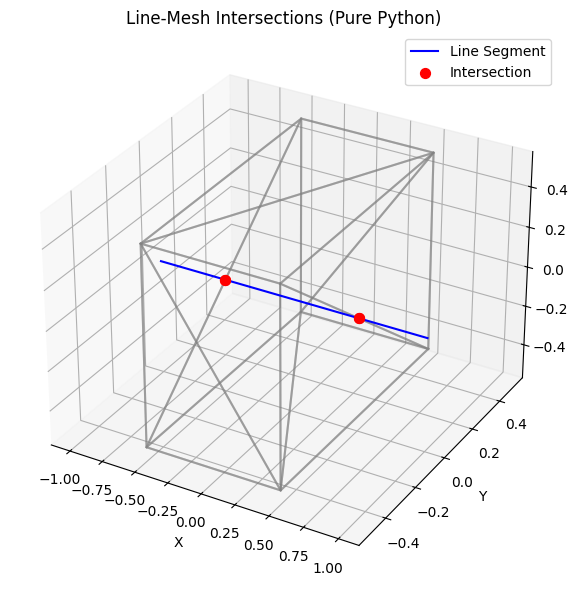

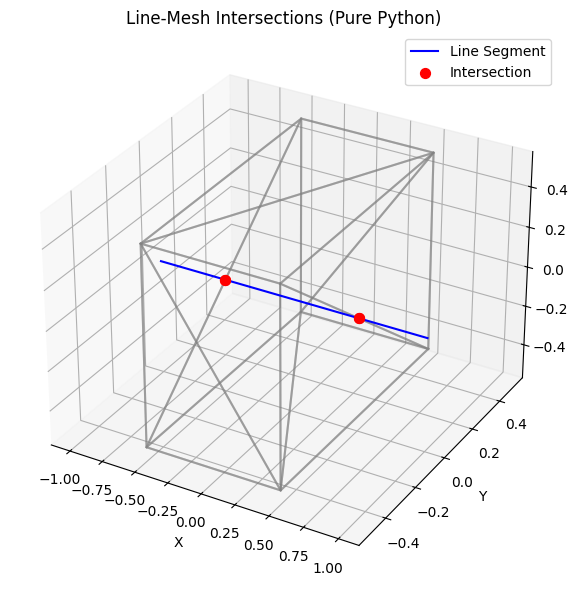

In [4]:
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from trimesh.creation import box

# Create a simple cube mesh (centered at origin, size 1x1x1)
cube = box(extents=(1, 1, 1))

# Define a line segment passing through the cube
p0 = np.array([-1, 0, 0])  # Start point
p1 = np.array([1, 0, 0])   # End point

# Möller–Trumbore ray-triangle intersection algorithm
def ray_intersects_triangle(p0, p1, tri):
    epsilon = 1e-8
    v0, v1, v2 = tri
    edge1 = v1 - v0
    edge2 = v2 - v0
    d = p1 - p0
    h = np.cross(d, edge2)
    a = np.dot(edge1, h)
    if abs(a) < epsilon:
        return None  # Parallel
    f = 1.0 / a
    s = p0 - v0
    u = f * np.dot(s, h)
    if not (0.0 <= u <= 1.0):
        return None
    q = np.cross(s, edge1)
    v = f * np.dot(d, q)
    if not (0.0 <= v <= 1.0) or (u + v > 1.0):
        return None
    t = f * np.dot(edge2, q)
    if 0.0 <= t <= 1.0:
        return p0 + t * d
    return None

# Check each face for intersection
intersections = []
for face in cube.faces:
    tri = cube.vertices[face]
    hit = ray_intersects_triangle(p0, p1, tri)
    if hit is not None:
        intersections.append(hit)

# ------------------- Plot with Matplotlib -------------------
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot cube edges
for face in cube.faces:
    tri = cube.vertices[face]
    tri = np.vstack([tri, tri[0]])  # close loop
    ax.plot(tri[:, 0], tri[:, 1], tri[:, 2], color='gray', alpha=0.5)

# Plot line segment
ax.plot([p0[0], p1[0]], [p0[1], p1[1]], [p0[2], p1[2]], color='blue', label='Line Segment')

# Plot intersection points
for pt in intersections:
    ax.scatter(pt[0], pt[1], pt[2], color='red', s=50, label='Intersection')

# Make sure labels don't duplicate in legend
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys())

# Set axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Line-Mesh Intersections (Pure Python)")

plt.tight_layout()
plt.show()


/tmp/ipykernel_917/3702943973.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


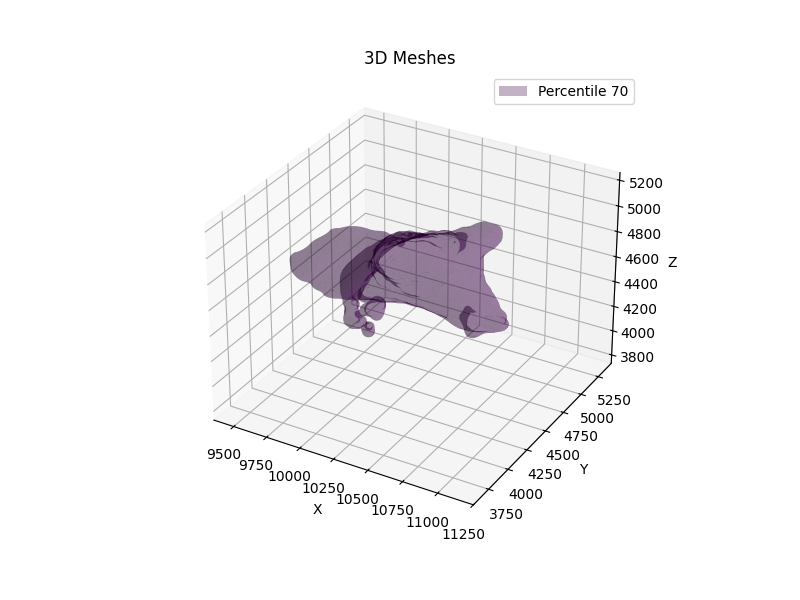

In [10]:
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# Load mesh using trimesh
percs = [70]
# load meshes

meshes = [trimesh.load_mesh(f'/root/capsule/data/LC_mesh/percentile_{perc}.obj') for perc in percs]
# Choose a colormap (e.g., 'viridis', 'plasma', 'inferno', etc.)
colormap = cm.get_cmap('viridis')
colors = [colormap(i / (4 - 1)) for i in range(4)]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
for ind, perc in enumerate(percs):
    mesh = meshes[ind]
    vertices = mesh.vertices
    faces = mesh.faces
    # Plot using matplotlib
    ax.plot_trisurf(vertices[:, 2], vertices[:, 1], faces, Z=vertices[:, 0],
                        color=colors[ind], alpha=0.3, edgecolors=None, label=f'Percentile {perc}')
# Labels and axis settings
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Meshes')
plt.legend()
plt.show()

